In [1]:
#Notebook to calculate APRP results for each month. 
#Do monthly kernels in a different script, and actual Gregory regressions in a 3rd script. 

#Need to calculate the APRP and radiative kernel results in individual years, 
#then take zonal mean and regress against zonal mean surface temperature change. 

#Started 18 June 2019

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

import APRPX as aprp

/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
#Climatological data for baseline for APRP
ds_clim = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')

In [4]:
#This requires loading the monthly means of everything that is necessary to calculate the feedbacks. 

In [5]:
model_filenames = {'AM2': 'AM21', 
                   'CAM3': 'CAM3', 
                   'CAM4': 'CAM4',
                   'CNRM-AM6-DIA-v2': 'CNRM-AM5', 
                   'ECHAM-6.1': 'ECHAM61', 
                   'ECHAM-6.3': 'ECHAM63', 
                   'GISS-ModelE2': 'GISS-ModelE2',
                   'IPSL-CM5A': 'LMDZ5A', 
                   'MIROC5': 'MIROC5', 
                   'MPAS': 'MPAS', 
                   'MetUM-GA6-CTL': 'MetUM-CTL', 
                   'MetUM-GA6-ENT': 'MetUM-ENT', 
                   'NorESM2': 'CAM5Nor'}

models = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1', 'ECHAM-6.3', 'GISS-ModelE2', 'IPSL-CM5A', 
              'MIROC5', 'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT', 'NorESM2']

models_12 = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2']

In [7]:
#Loop through the models and create a Dataset object for each one
#including monthly outputs all the variables relevant for APRP.

#Regrid these to the same lat/lon grid as the climatology so I can run APRP. 
#How did I do this before?
#ds_zm_i = ds_zm.interp(coords = {'time': ds_zm.time.data, 'lat': ds_climo.lat.data})
#Did that in 1D for "GregoryTRACMIP". 
#But I want to do 2D interpolation, not sure if it's OK to run APRP on zonal means already taken. 


#Which variables do I need? 
#8 for APRP: 
#rsds
#rsus
#rsut
#rsdt
#rsutcs
#rsdscs
#rsuscs
#clt
#Also need surface temperature to regress against.

#Change clt pervcent to fraction. (Note I can't seem to fix the units for this in the NetCDF metadata.)

vars_APRP = ['rsds', 'rsus', 'rsut', 'rsdt', 'rsutcs', 'rsdscs', 'rsuscs', 'clt', 'ts']
for model in models_12:
#for model in ['NorESM2']: #Was getting weird permission error for this model; deleted old file and re-saved here
#for model in ['CAM4']:
    #1. Load the XArray monthly output files for each variable for this model from NetCDF
    print('Saving monthly mean variables for APRP: ' + model)
    ds_temp = dict()
    for var in vars_APRP:
        ds_temp[var] = xr.open_dataset(glob.glob('../nc_esgf/Amon/'+var+'_Amon_'+model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
        if var == 'clt': #convert cloud fraction from percent to fraction
            print(ds_temp[var][var])
            if np.any(ds_temp[var][var].data > 1):
                ds_temp[var][var] = ds_temp[var][var] / 100.
                print(ds_temp[var][var])
    #2. Define Dataset combining them
    ds_all = xr.merge(ds_temp.values())
    print(ds_all)
    #3. Save to new NetCDF file
    ds_all.to_netcdf('nc_from_xarray/monthlyForGregAPRP_a4_'+model+'.nc')
    
    #Huh?... to_netcdf is converting the cloud fractions back to percentages
    
    #But only for CAM4

Saving monthly mean variables for APRP: AM2
<xarray.DataArray 'clt' (time: 480, lat: 90, lon: 144)>
[6220800 values with dtype=float32]
Coordinates:
  * time     (time) object 0046-01-16 00:00:00 ... 0085-12-16 00:00:00
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Attributes:
    standard_name:     cloud_area_fraction
    long_name:         Total Cloud Fraction
    comment:           for the whole atmospheric column, as seen from the sur...
    units:             %
    original_name:     clt
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2019-01-13T19:48:52Z altered by CMOR: replaced missing...
    associated_files:  baseURL: https://www.sites.google.com/site/tracmip/ gr...
<xarray.DataArray 'clt' (time: 480, lat: 90, lon: 144)>
array([[[0.990149, 0.990149, ..., 0.990149, 0.990149],
        [0.987077, 0.988459, ..., 0.98625 , 

In [8]:
#Test loading one of the above
test = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_CAM4.nc')
print(test)
print(test['clt'].isel(time=0))

#Why won't it assign the corrected data?
#OK, it did... bug in Jupyter? Was keeping old object in memory. 
#Fixed by restarting kernel and clearing output

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 480)
Coordinates:
  * time       (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    rsds       (time, lat, lon) float32 ...
    rsus       (time, lat, lon) float32 ...
    rsut       (time, lat, lon) float32 ...
    rsdt       (time, lat, lon) float32 ...
    rsutcs     (time, lat, lon) float32 ...
    rsdscs     (time, lat, lon) float32 ...
    rsuscs     (time, lat, lon) float32 ...
    clt        (time, lat, lon) float32 ...
    ts         (time, lat, lon) float32 ...
<xarray.DataArray 'clt' (lat: 96, lon: 144)>
array([[0.964077, 0.964077, 0.964077, ..., 0.964077, 0.964077, 0.964077],
  

In [9]:
#Having compiled these datasets, needed to regrid the output. 
#Did this in script: "regrid_data_forGregory.py"
#Run in regular Python shell

In [10]:
#Check the regridding script worked:
ds_test2 = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_CAM4.nc')
print(ds_test2)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
Data variables:
    rsds     (time, lat, lon) float64 ...
    rsus     (time, lat, lon) float64 ...
    rsut     (time, lat, lon) float64 ...
    rsdt     (time, lat, lon) float64 ...
    rsutcs   (time, lat, lon) float64 ...
    rsdscs   (time, lat, lon) float64 ...
    rsuscs   (time, lat, lon) float64 ...
    clt      (time, lat, lon) float64 ...
    ts       (time, lat, lon) float64 ...


In [ ]:
# #Check whether longitude from 0 to 360 is an issue
# for mod in models_12:
#     ds_temp = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_'+mod+'.nc')
#     print(mod)
#     print(ds_temp.lon)
#
# print(ds_clim.lon)    

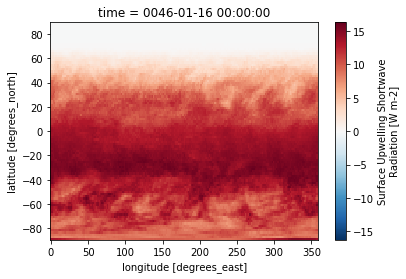

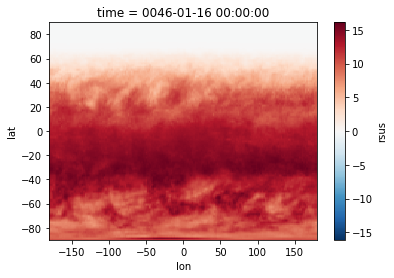

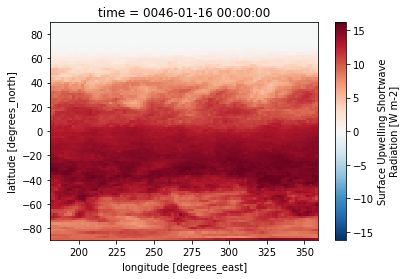

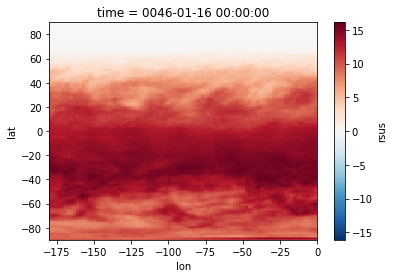

In [11]:
#Regridding appears to have worked. 
#Plot two example variables in both versions to make sure they still look similar
plt.figure()
test1 = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_ECHAM-6.1.nc')
test1['rsus'].isel(time=0).plot()
plt.figure()
test2 = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_ECHAM-6.1.nc')
test2['rsus'].isel(time=0).plot()
#Longitude offset makes things weird. Plot only western hemisphere
plt.figure()
test1['rsus'].isel(time=0).sel(lon=test1.lon[test1.lon>180]).plot()
plt.figure()
test2['rsus'].isel(time=0).sel(lon=test2.lon[test2.lon<0]).plot()


#OK, I'm satisfied it looks the same. 

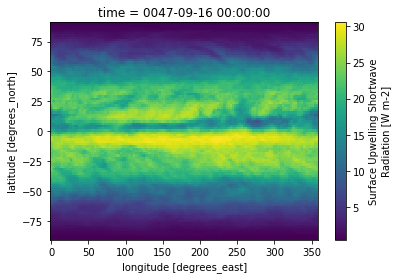

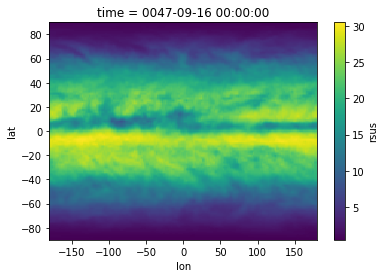

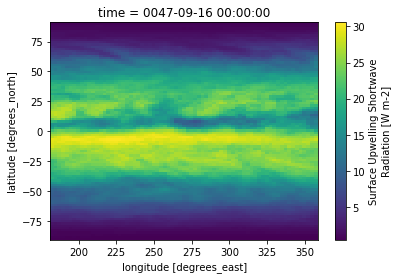

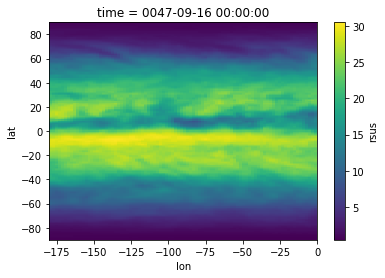

In [12]:
#Try another model to make sure they look different
plt.figure()
test1 = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_CAM4.nc')
test1['rsus'].isel(time=20).plot()
plt.figure()
test2 = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_CAM4.nc')
test2['rsus'].isel(time=20).plot()
#Longitude offset makes things weird. Plot only western hemisphere
plt.figure()
test1['rsus'].isel(time=20).sel(lon=test1.lon[test1.lon>180]).plot()
plt.figure()
test2['rsus'].isel(time=20).sel(lon=test2.lon[test2.lon<0]).plot()

In [13]:
###   Main Computations   ###

#Loop through the models, run APRP on each month and save to NetCDF datasets
#This is done using the "aprp_main_TRACMIP_2Datasets" wrapper function in the 
#"APRPX.py" module.
#For each month, use "i%12" to extract month of the year in the climatology 
#that corresponds to the month of the perturbation run being analyzed.
#We don't have any models starting in December, do we?

In [16]:
ds_APRP_monthly_dict = dict()
for model in models_12:
    ds_temp = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')
    print(ds_temp)
    numMonths = len(ds_temp.time)
    print('Running monthly APRP: ' + model + '; ' + str(numMonths/12) + ' years')
    sub_temp_dict = dict()
    #Run APRP for each month
    for i in np.arange(numMonths):
        ds_clim_i = ds_clim.sel(model=model).isel(time=i%12)
        if i % 20 == 0:
            print('month '+str(i))
            #Debug output and plots
#             print(ds_clim_i)
#             print(ds_temp.isel(time=i))
#             plt.figure()
#             #plt.pcolor(ds_clim_i['rsus'].data)
#             plt.pcolor(ds_clim_i['clt'].values)
#             plt.colorbar()
            
#             plt.figure()
#             #plt.pcolor(ds_temp.isel(time=i)['rsus'].data)
#             plt.pcolor(ds_temp.isel(time=i)['clt'].values)
#             plt.colorbar()
#             #plt.pcolor(ds_temp.isel(time=i)['rsus'].transpose().data)
        sub_temp_dict[i] = aprp.aprp_main_TRACMIP_2Datasets(ds_clim_i, ds_temp.isel(time=i))
    #Concatenate each month into a new Dataset
    ds_APRP_monthly_dict[model] = xr.concat(sub_temp_dict.values(), dim='time')
    ds_APRP_monthly_dict[model].to_netcdf('nc_from_xarray/APRP_monthly_results_a4_'+model+'.nc')

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0046-01-16 00:00:00 ... 0085-12-16 00:00:00
Data variables:
    rsds     (time, lat, lon) float64 ...
    rsus     (time, lat, lon) float64 ...
    rsut     (time, lat, lon) float64 ...
    rsdt     (time, lat, lon) float64 ...
    rsutcs   (time, lat, lon) float64 ...
    rsdscs   (time, lat, lon) float64 ...
    rsuscs   (time, lat, lon) float64 ...
    clt      (time, lat, lon) float64 ...
    ts       (time, lat, lon) float64 ...
Running monthly APRP: AM2; 40.0 years
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
<xarray.Dataset>
Dimensions:  